# Import Libraries

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import pathlib
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.regularizers as R
import tensorflow.keras.backend as B

# Visulization

In [2]:
class ImgsVisulization():
    def __init__(self):
        pass

    def img(self, img, title=None, dpi=100):
        plt.rcParams['savefig.dpi'] = dpi
        plt.rcParams['figure.dpi'] = dpi
        if title is not None:
            plt.title(title)
        if len(img.shape) == 2:
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(img)
        plt.show()

    def imgs(self, imgs, title=None, dpi=100):  
        plt.rcParams['savefig.dpi'] = dpi
        plt.rcParams['figure.dpi'] = dpi
        for i in range(len(imgs)):
            max_row = 12
            if len(imgs) > max_row:
                plt.subplot(math.ceil(len(imgs) / max_row), max_row, i + 1)
            else:
                plt.subplot(1, len(imgs), i + 1)
            plt.axis('off')
            if title is not None:
                plt.title(title[i])
            if len(imgs[i].shape) == 2:
                plt.imshow(imgs[i], cmap='gray', vmin=0, vmax=255)
            else:
                plt.imshow(imgs[i])
        plt.subplots_adjust(wspace=0.00, hspace=0.00)
        plt.show()
    
imgs_visulization = ImgsVisulization()

# Load Samples

(720, 540, 3) (720, 540, 3)


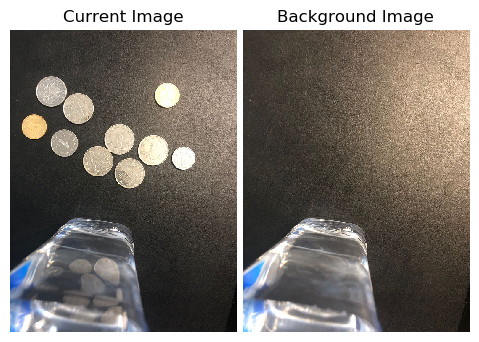

In [3]:
sample_img_curr = plt.imread('E:\Documents\Others\Desktop\WIn10\Desktop\WeChat Image_20201002173451.jpg')
sample_img_bg = plt.imread('E:\Documents\Others\Desktop\WIn10\Desktop\WeChat Image_20201002173440.jpg')

print(sample_img_curr.shape, sample_img_bg.shape)
imgs_visulization.imgs([sample_img_curr, sample_img_bg], ["Current Image", "Background Image"])

# Roi Pooling

In [4]:
class RoiPooling():
    def __init__(self, distance):
        self.distance = distance
        self.holes_fill_threshold = 70
        self.bg_threshold = 60
        self.min_radius = 10
        self.max_radius = 1000
    
    def _foreground_extract(self, img_curr, img_bg):
        img_curr = cv2.cvtColor(img_curr, cv2.COLOR_RGB2GRAY)
        img_bg = cv2.cvtColor(img_bg, cv2.COLOR_RGB2GRAY)
        img_bg = cv2.GaussianBlur(img_bg, (3, 3), 5)
        img_curr = cv2.GaussianBlur(img_curr, (3, 3), 5)

        res = np.where(img_curr > img_bg, img_curr - img_bg, img_bg - img_curr)
        res = np.where(res > self.bg_threshold, 255, 0).astype(np.uint8)
        #res = cv2.morphologyEx(res, cv2.MORPH_CLOSE, np.ones((3, 3),np.uint8))
        contours, _ = cv2.findContours(255 - res, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        contours = [contour for contour in contours if cv2.contourArea(contour) <= self.holes_fill_threshold]
        res = cv2.drawContours(res, contours, -1, (255, 255, 255), -1)
        return res
    
    def _segmentation(self, img_curr, mask):
        # Find all peaks of "distanceTransform"
        dist_transform = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        loc_max = np.logical_and(cv2.dilate(dist_transform, np.ones((3, 3),np.uint8)) == dist_transform,
                                 np.logical_and(dist_transform > self.min_radius, dist_transform < self.max_radius))
        loc_max = [(x, y, math.ceil(dist_transform[y, x])) for y in range(loc_max.shape[0]) for x in range(loc_max.shape[1]) if loc_max[y, x]]
        loc_max.sort(key=lambda x: x[-1], reverse=True)
        # Filter points on the borders
        closed_mask = np.zeros(mask.shape, np.uint8)
        res = []
        for (x, y, r) in loc_max:
            if closed_mask[y, x] == 0:
                res.append((x, y, r))
                cv2.circle(closed_mask, (x, y), int(r * 1.2), 255, -1)
        return res
    
    def get_roi_info(self, img_curr, img_bg):
        fg_mask = self._foreground_extract(img_curr, img_bg)
        # imgs_visulization.img(fg_mask, "Foreground Detection")
        proposals = self._segmentation(img_curr, fg_mask)
        return proposals

    def get_roi_img(self, img, proposals, mode=0):
        if mode == 0:
            img_canvas = img.copy()
            for (x, y, r) in proposals:
                cv2.circle(img_canvas, (x, y), int(r), (0, 0, 255), 3)
            return img_canvas
        elif mode == 1:
            return [img[max(y - r, 0):(y + r), max(x - r, 0):(x + r), :] for (x, y, r) in proposals]
    
roi_pooling = RoiPooling(5)

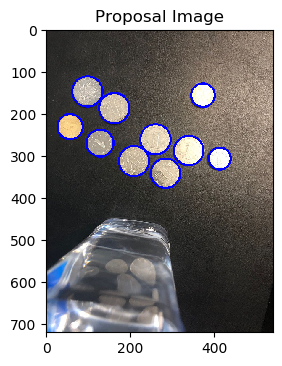

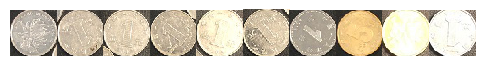

In [5]:
sample_proposals = roi_pooling.get_roi_info(sample_img_curr, sample_img_bg)
imgs_visulization.img(roi_pooling.get_roi_img(sample_img_curr, sample_proposals, mode=0), "Proposal Image")
imgs_visulization.imgs(roi_pooling.get_roi_img(sample_img_curr, sample_proposals, mode=1))

# Classification Coins

In [6]:
class MetricLearningModel():
    class ResizeLayer(L.Layer):
        def __init__(self, resize_shape, **kwargs):
            super().__init__(**kwargs)
            self.resize_shape = resize_shape

        def call(self, inputs: tf.Tensor, **kwargs):
            inputs = tf.image.resize(inputs, self.resize_shape[:2])
            return inputs

    class L2NormLayer(L.Layer):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            pass

        def call(self, inputs: tf.Tensor, **kwargs):
            inputs = tf.math.l2_normalize(inputs, axis=1)
            return inputs
        
    def __init__(self):
        image_shape = (224, 224, 3)
        input = tf.keras.Input(shape=image_shape, name='Input')
        #x = ResizeLayer(resize_shape=image_shape)(input)
        #backbone = efn.EfficientNetB0(input_shape=image_shape, include_top=False, weights='imagenet')
        backbone = tf.keras.applications.MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
        x = backbone(input)
        x = L.GlobalAveragePooling2D(name='Gap')(x)
        x = L.Dense(256, name='Dense', activation=None)(x)
        x = self.L2NormLayer(name="L2")(x)
        output = x
        self.model = tf.keras.Model(input, output, name='Model')
        self.image_shape = image_shape
        
        #self.model.summary()
        
    def load_weights(self, path):
        self.model.load_weights(path, by_name=True, skip_mismatch=True)
        
    def extract_features(self, imgs, steps=None):
        imgs = np.stack([cv2.resize(img, self.image_shape[:2]) for img in imgs])
        return self.model.predict(imgs, verbose=1, steps=steps)
    
    @tf.function
    def _cos_similarity_iter(self, embedding_target, embedding_sources, k):
        distances = tf.matmul(embedding_sources, tf.expand_dims(embedding_target, axis=-1))[:,0] # (#embedding_sources)
        nearset_distances, nearest_idxs = tf.math.top_k(distances, k=k, sorted=True)
        nearset_distances, nearest_idxs = tf.cast(nearset_distances, tf.float32), tf.cast(nearest_idxs, tf.float32)
        return tf.stack([nearest_idxs, nearset_distances], axis=1) #(3, 2)
    
    @tf.function
    def cos_similarity(self, embedding_targets, embedding_sources, k):
        return tf.map_fn(lambda x: self._cos_similarity_iter(x, embedding_sources, k), embedding_targets)
    
features_extractor = MetricLearningModel()
features_extractor.load_weights("E:\\Documents\\Others\\Desktop\\WIn10\\Desktop\\model_84_40.1671_0.8475_0.00009.h5")

In [7]:
sample_features = features_extractor.extract_features([sample_img_curr, sample_img_bg])
similarities = features_extractor.cos_similarity(sample_features, sample_features, 1)
print(similarities)

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Model/mobilenetv2_1.00_224/Conv1/Conv2D (defined at <ipython-input-6-3c01aca7545c>:41) ]] [Op:__inference_predict_function_8504]

Function call stack:
predict_function


In [ ]:
class Detection():
    def __init__(self):
        train_paths = [str(x) for x in tqdm(pathlib.Path("E:\\Documents\\Others\\Desktop\\WIn10\\Desktop\\archive\\coins\\data\\test").rglob('*.jpg'))]
        self.train_label = [path.split("\\")[-2] for path in train_paths]
        self.train_features = features_extractor.extract_features([plt.imread(path) for path in train_paths])

    def detect(self, imgs, rerank=5, score_thresold=0.6):
        test_features = features_extractor.extract_features(imgs)
        similarities = features_extractor.cos_similarity(test_features, self.train_features, rerank) # (?, rerank, 2)
        summary = {}
        for v0 in similarities:
            summary_iter = {}
            for v1 in v0: # Iterate Rerank
                label, similarity = self.train_label[int(v1[0])], v1[1].numpy()
                if similarity >= score_thresold:
                    summary_iter[label] = similarity + (summary_iter[label] if (label in summary_iter) else 0)
            if (len(summary_iter.keys()) > 0):
                label = max(zip(summary_iter.values(), summary_iter.keys()))[1]
                summary[label] = 1 + (summary[label] if (label in summary) else 0)
        return summary
    
detection = Detection()

In [ ]:
detection.detect(roi_pooling.get_roi_img(sample_img_curr, sample_proposals, mode=1))